1. [Problem Statement](#problem_statement)
2. [Import Libraries](#import_libraries)
3. [Set Notebook Formatting](#set_notebook_formatting)
4. [Data Loading](#data_loading)
5. [Data Exploration](#data_exploration)
6. [Preprocessing](#preprocessing)
7. [Modelling](#modelling)
8. [Question - Cross Validation](#question_cross_validation)



### 1. Problem Statement <a id="problem_statement"></a>

#### Air Pollution Forecasting
We need to build a simple neural network to forecast the Benzene concentration in air.

The dataset contains hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device and ground truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) provided by a co-located reference certified analyzer.
Missing values are tagged with -200 value.

Attribute Information:

1.  Date (DD/MM/YYYY)
2.  Time (HH.MM.SS)
3.  True hourly averaged concentration CO in mg/m^3 (reference analyzer)
4.  PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
5.  True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
6.  True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
7.  PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
8.  True hourly averaged NOx concentration in ppb (reference analyzer)
9.  PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
10. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
11. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
12. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
13. Temperature in °C
14. Relative Humidity (%)
15. AH Absolute Humidity

- Load the dataset and perform the standard steps you would do in any data science project, e.g: data exploration, data cleaning, preprocessing etc.
- Train and evaluate a neural network for **time series** (RNN or similar) to predict Benzene concentration at the
  next hour. You can use Pytorch, Tensowflow(Keras) or Theano.
- How would you apply cross validation to the model? (No code implementation required, just description of the methodology)

Explain each of these steps and discuss the results.

### 2. Import Libraries <a id="import_libraries"></a>

In [64]:
#pip install -r requirements.txt
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from functools import reduce
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

### 3. Set Notebook Formatting <a id="set_notebook_formatting"></a>

In [65]:
#Ignore warnings
warnings.filterwarnings('ignore')

# Create fontdicts for formatting figure text
axtitle_dict = {'family': 'serif','color':  'darkred','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}

# Set the options to display all columns and unlimited width
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### 4. Data Loading <a id="data_loading"></a>
- The dataset is loaded to a dataframe. 
- Missing values represented by "-200" are replaced with NaNs.

In [66]:
#Locate and load data to a single dataframe
file_name='AirQualityUCI.csv'
folder_path = os.path.join(os.getcwd())
df = pd.read_csv(os.path.join(folder_path, file_name), sep=';')
df = df.drop_duplicates() #No duplicates found on inspection
df=df.replace(-200, np.nan)

### 5. Data Exploration <a id="data_exploration"></a>
- The dataset includes data for all hours of every day. There's no need to add new rows to the table.
- The time series reveals a high variance in gas concentrations from October 2004 onwards.
- The daily average concentration of benzene peaks at 8am and 7pm, together with other gases indicating correlation.
- The hourly variance of benzene is lowest in the range from 0 to 7am..
- Pearson correlations between pairs of features show:
    - Strong relationships between gas concentrations. 
    - However, correlations between gas concentrations and T (Temperature),AH (Absolute Humidity) and RH (Relative Humidity) are typically weak.
    - Benzene correlates particularly strongly with PT08.S2 (NMHC) (0.98), CO(GT) 0.93 and MMHC(GT) 0.9.
- Scatter plots between pairs of features indicate that some of the relationships are better explained by nonlinear dynamics. 
- The column NMHC(GT) contains 90% nulls. We can't use this feature.
- The rest of the columns contain some percentage of nulls (<20%). Since the proportions are not too high, we can look into infilling them based on the rest, given how correlated the gases are. Removing nulls can impact the time series, that is why it's not a preferred option in this case.
- Most of the times, there is only one feature missing at a given time (6k/9k rows have only 1 missing value in the set of features).This suggests infilling methods like KNN can be suitable.
- Feature autocorrelations are strong within the hour. Linear interpolation may suit the infilling of sparse missing values as a first approach.
- Long-term autocorrelations seen (>30hs) in the data. Perhaps worth trying LSTM apart from RNN? LSTM may better capture long-term relationships in the time series.




In [67]:
#How does my data look like?
df.head(3)

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  2004-03-11  00:00:00     1.2      1185.00      31.0  3.624399   
1  2004-03-11  01:00:00     1.0      1136.25      31.0  3.326677   
2  2004-03-11  02:00:00     0.9      1094.00      24.0  2.339416   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0          689.5     62.0       1461.75     77.0       1332.75        732.5   
1          672.0     62.0       1453.25     76.0       1332.75        729.5   
2          608.5     45.0       1579.00     60.0       1276.00        619.5   

        T         RH        AH  
0  11.325  56.775000  0.760312  
1  10.675  60.000000  0.770238  
2  10.650  59.674999  0.764819

All the hours of all the days are included in the dataset. There's no need to add new rows to the table.

In [68]:
#Are there rows missing in the dataset? No, there are exactly 388 days of data for each timeframe.
print("Max days per hour in the data:", df.groupby(["Time"]).size().max())
print("Min days per hour in the data:", df.groupby(["Time"]).size().min())

Max days per hour in the data: 388
Min days per hour in the data: 388


In [69]:
#What are the data types of my dataframe?
df.dtypes

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

In [70]:
#Let's get a sense of the scale units, mean, min, max, quartiles and std of the different gases.
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7630.000000  8946.000000   908.000000  8946.000000    8946.000000   
mean      2.156212  1099.896117   219.686123    10.102310     939.778244   
std       1.454605   217.264646   204.828300     7.455845     266.887481   
min       0.100000   647.250000     7.000000     0.149048     383.250000   
25%       1.100000   936.750000    67.000000     4.453477     735.250000   
50%       1.800000  1063.500000   150.500000     8.255224     909.625000   
75%       2.900000  1231.250000   299.000000    14.009666    1116.937500   
max      11.900000  2039.750000  1189.000000    63.741476    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7673.000000   8946.000000  7670.000000   8946.000000  8946.000000   
mean    247.186863    835.244579   113.067757   1457.785342  1023.598359   
std     213.309345    257.036315    48.389177    345.841787   398.566418   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    657.750000    78.000000   1230.562500   732.812500   
50%     180.000000    804.750000   109.000000   1463.750000   963.750000   
75%     326.100000    969.000000   141.900000   1675.000000  1274.187500   
max    1479.000000   2682.750000   339.700000   2775.000000  2522.750000   

                 T           RH           AH  
count  8946.000000  8946.000000  8946.000000  
mean     18.322364    49.281075     1.027303  
std       8.841108    17.304117     0.403957  
min      -1.900000     9.175000     0.184679  
25%      11.800000    35.874999     0.737994  
50%      17.750000    49.575000     0.997302  
75%      24.400000    62.550000     1.315327  
max      44.600000    88.725000     2.231036

The time series reveals a high variance in gas concentrations from 2004-10 onwards.

<Axes: xlabel='Date'>

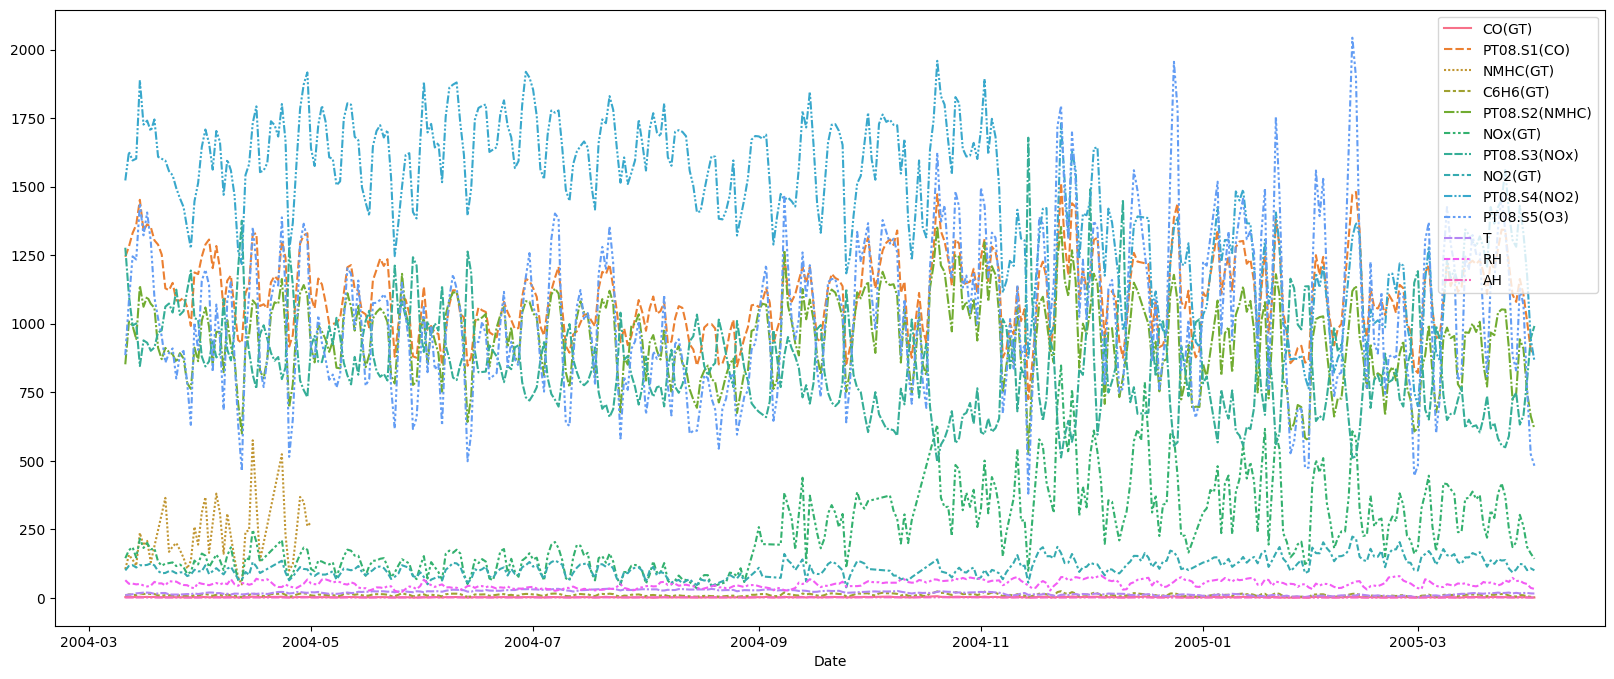

In [71]:
#Let's plot the daily average concentration for each gas 
df["Date"] = pd.to_datetime(df["Date"])
column_list=[ 'CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']
result = df.groupby(["Date"])[column_list].mean()
plt.figure(figsize=(20, 8))
sns.lineplot( data=result)

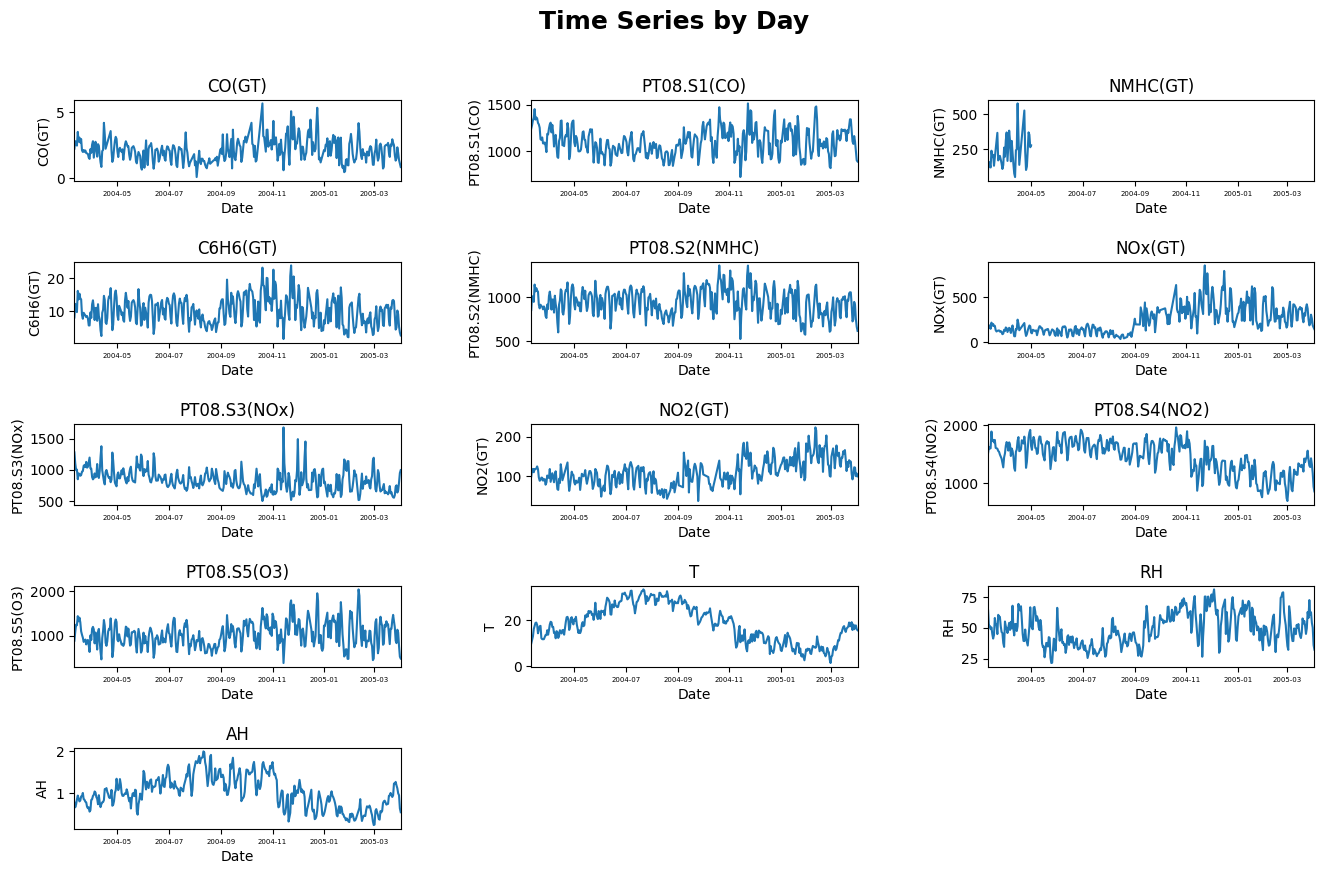

In [72]:
#Get the average concentration by day and type of gas
categ_columns=[ 'CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']
fig = plt.figure(figsize=[16,15])
fig.suptitle('Time Series by Day', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=1, wspace=0.4);
index_min = result.index.min()
index_max = result.index.max()
for i , columns in enumerate(categ_columns):
    input = np.unique(result[columns] , return_counts = True)
    col= 'input'
    ax1 = fig.add_subplot(8, 3, i+1);
    ax1 = sns.lineplot( x="Date",y= columns ,data=result)
    ax1.set_title(f'{columns}')
    ax1.tick_params(axis='x', labelsize=5)
    ax1.set_xlim([index_min, index_max])

The daily average concentration of benzene peaks at 8am and 7pm, together with other gases indicating correlation.


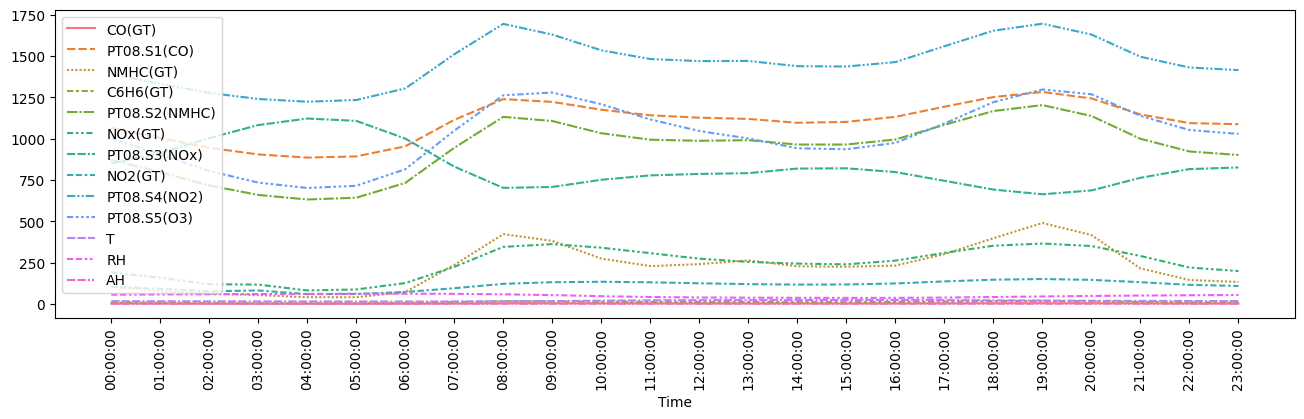

In [73]:
#Let's plot the time series by day for each gas
column_list=[ 'CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']
result = df.groupby(["Time"])[column_list].mean()
plt.figure(figsize=(16, 4))
sns.lineplot( data=result)
plt.tick_params(axis="x", labelrotation=90)


The hourly variance of benzene is lowest in the range 0-7am.

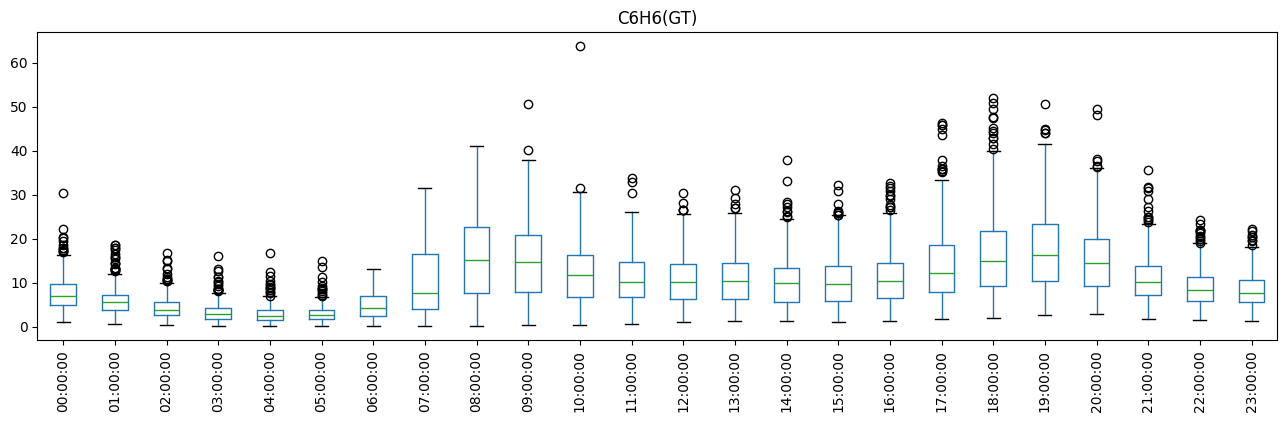

In [74]:
pivoted_df = df.pivot(index='Date', columns='Time', values='C6H6(GT)')
plt.figure(figsize=(16, 4))
pivoted_df.boxplot()
plt.tick_params(axis="x", labelrotation=90)
plt.title('C6H6(GT)')
plt.grid(False)
plt.show()

- Pearson correlation between pairs of features show:
    - Strong relationships between gases concentrations. 
    - However, correlations between gases concentrations and T (Temperature),AH (Absolute Humidity) and RH (Relative Humidity) are typically weak.
    - Benzene correlates particularly strongly with PT08.S2 (NMHC) (0.98), CO(GT) 0.93 and MMHC(GT) 0.9.

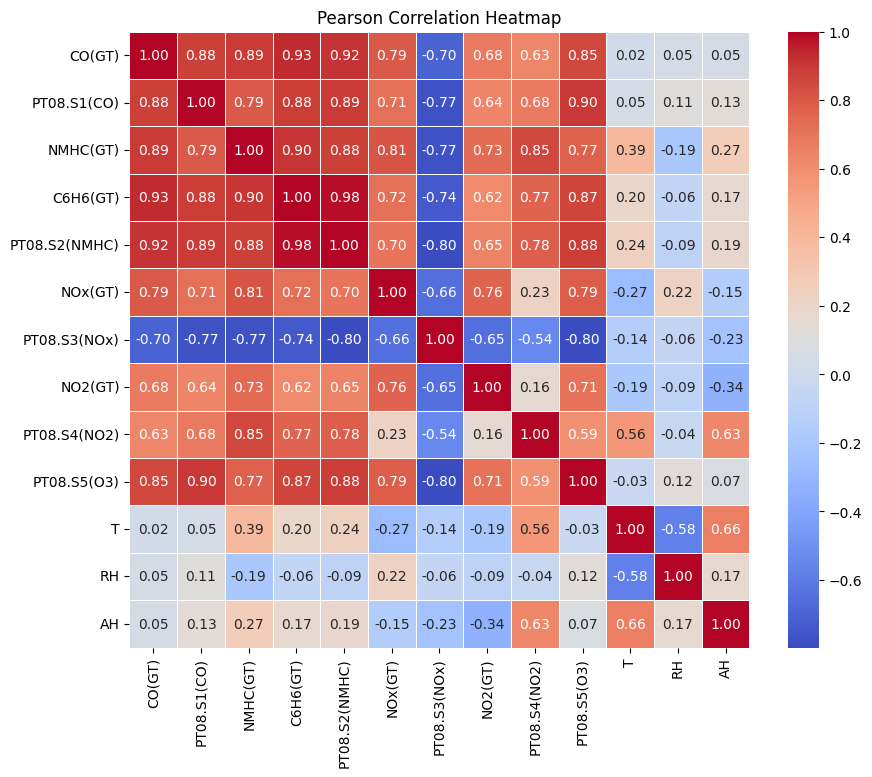

In [75]:
#Let's see the correlations between fields
dfs=df.copy()
dfs = dfs.drop('Date', axis=1)
dfs = dfs.drop('Time', axis=1)
scaler = StandardScaler()  # or MinMaxScaler()
numerical_columns = dfs.select_dtypes(include='float64').columns
dfs[numerical_columns] = scaler.fit_transform(dfs[numerical_columns])
correlation_matrix = dfs.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

Scatter plots between pairs of features indicate that some of the relationships are better explained by non-linear functions.

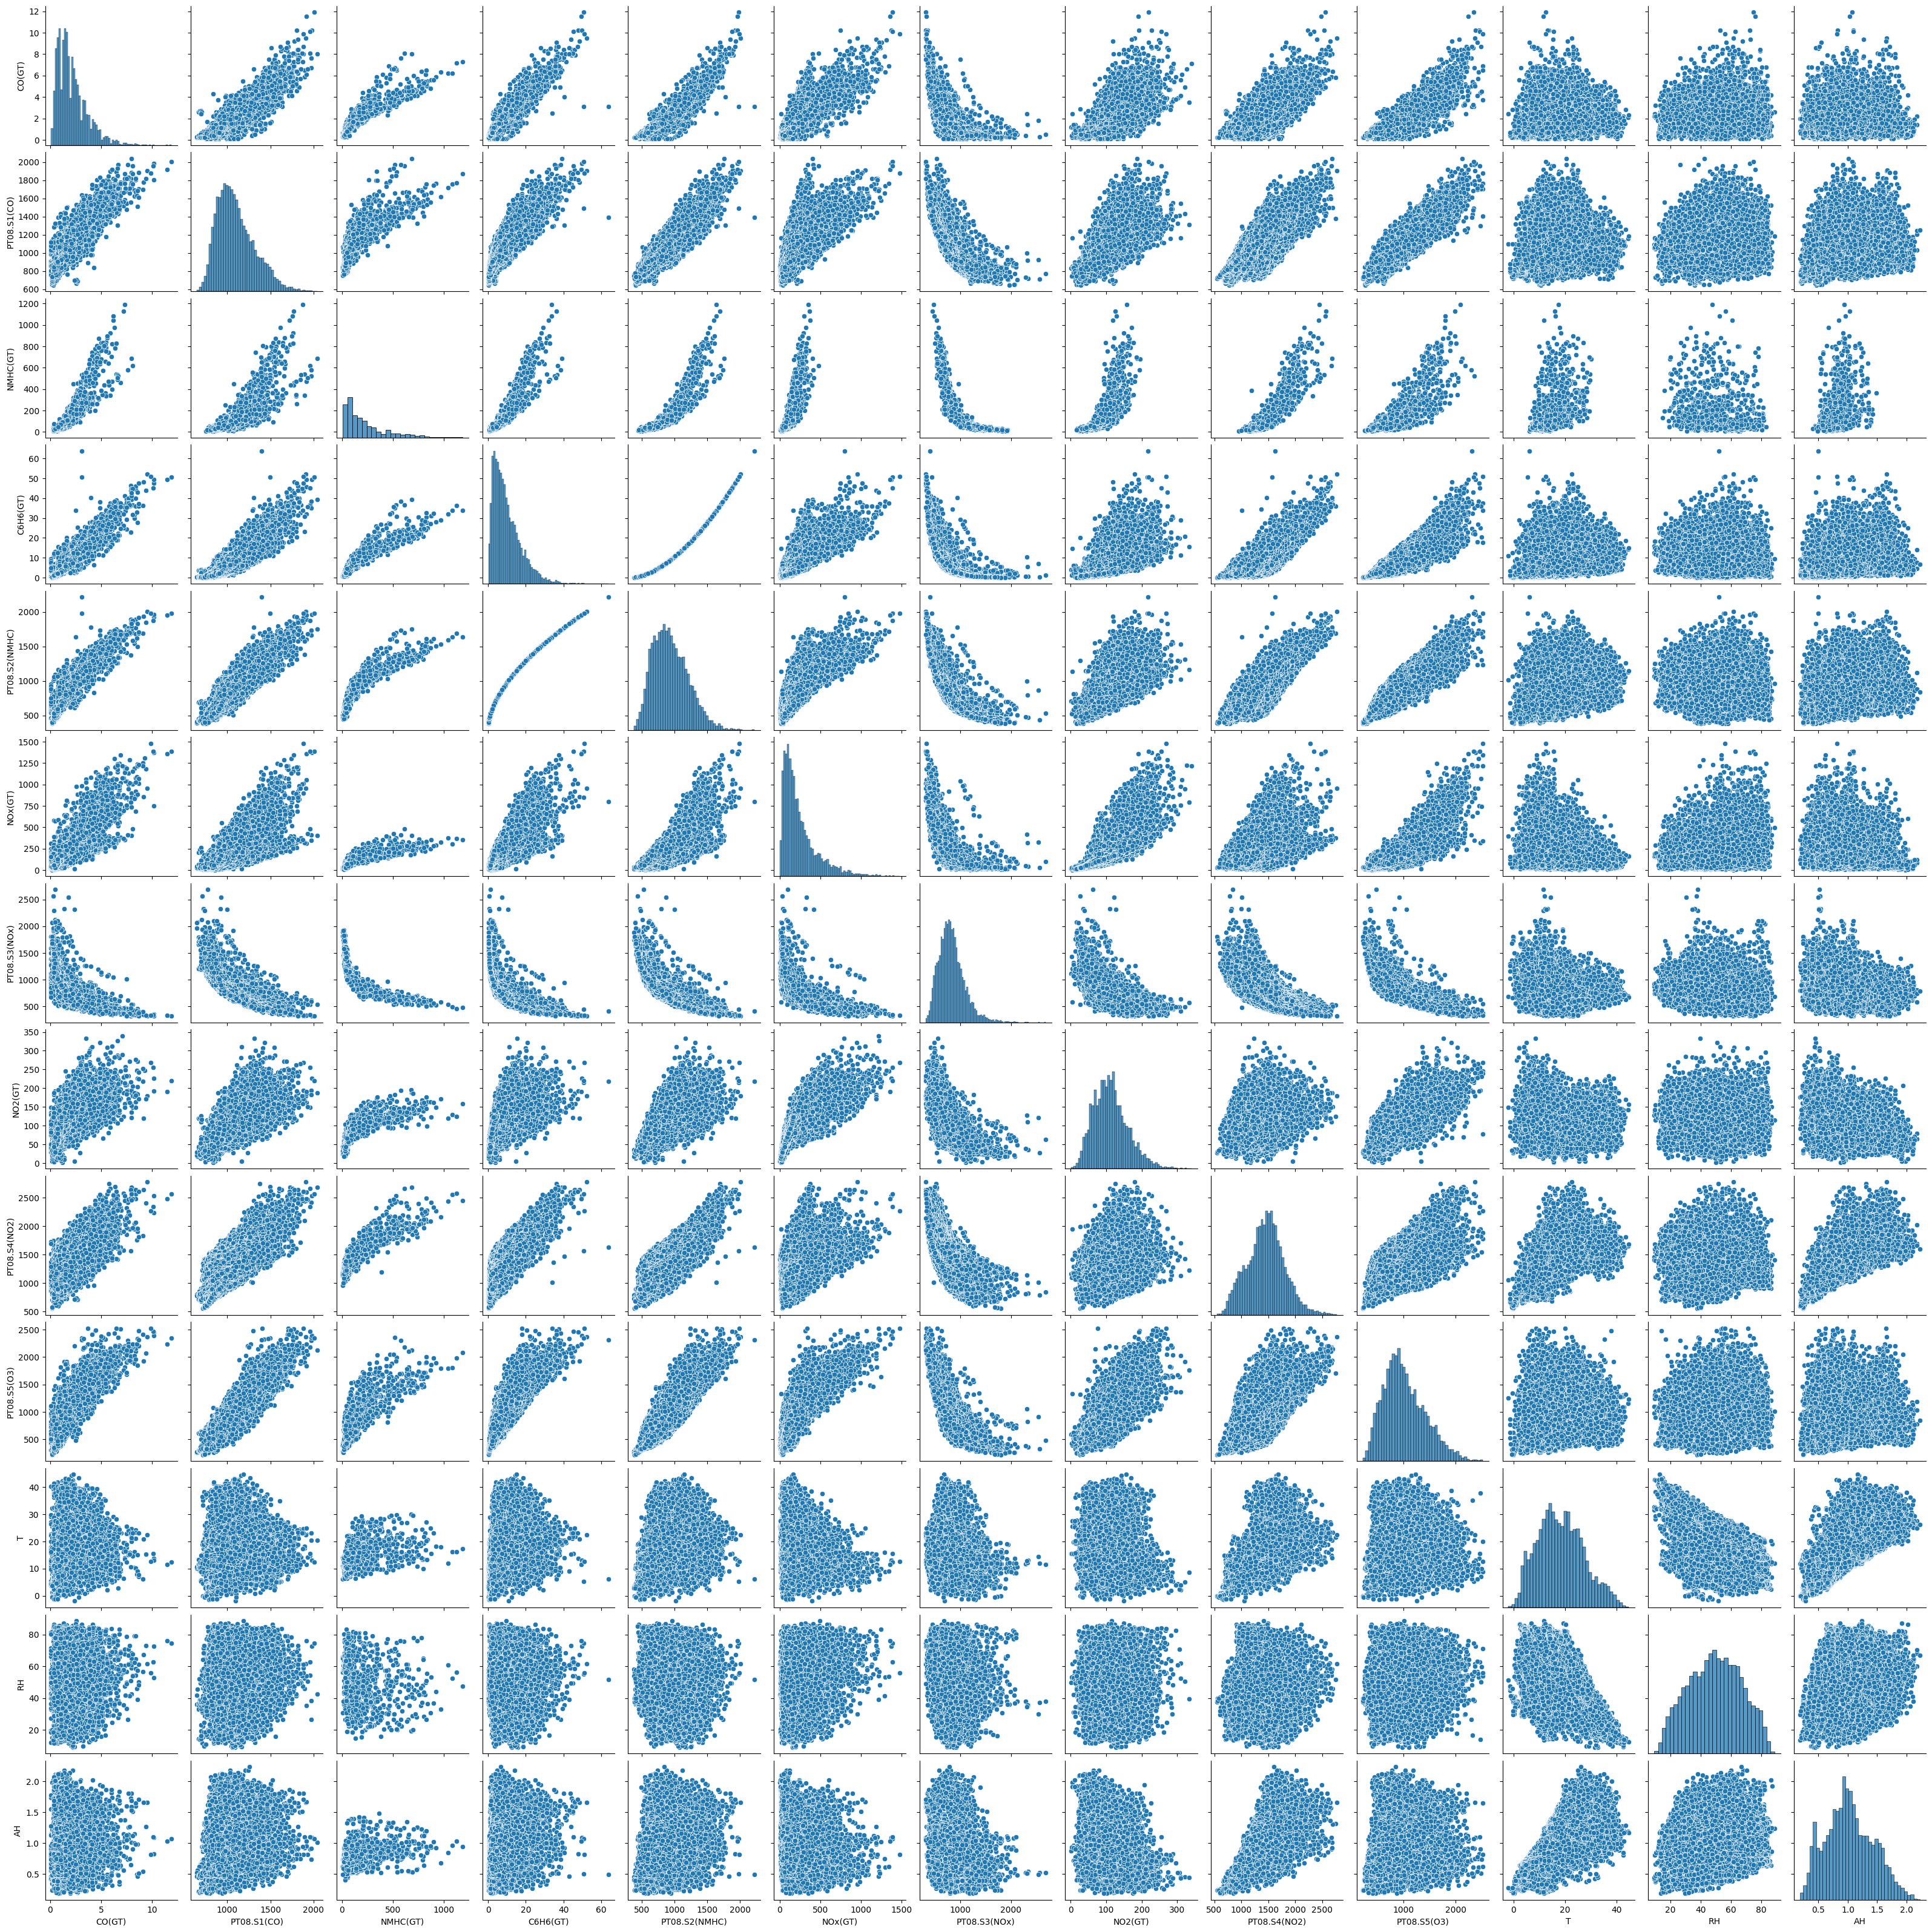

In [76]:
sns.pairplot(df)

- The column NMHC(GT) contains 90% nulls. We can't use this feature.
- The rest of columns contain some percentage of nulls (<20%). Since proportions are not too high, we can look into infilling them based on the rest given how correlated the gases are. Removing nulls can impact the time series, that is why it's not a preferred option in this case.

In [77]:
#Let's get the percentage of missing values
percentage_by_column = df.apply(lambda col: round(col.isnull().sum() / len(col) * 100, 2))
print(percentage_by_column)

Date              0.00
Time              0.00
CO(GT)           18.06
PT08.S1(CO)       3.93
NMHC(GT)         90.25
C6H6(GT)          3.93
PT08.S2(NMHC)     3.93
NOx(GT)          17.60
PT08.S3(NOx)      3.93
NO2(GT)          17.63
PT08.S4(NO2)      3.93
PT08.S5(O3)       3.93
T                 3.93
RH                3.93
AH                3.93
dtype: float64


<Axes: >

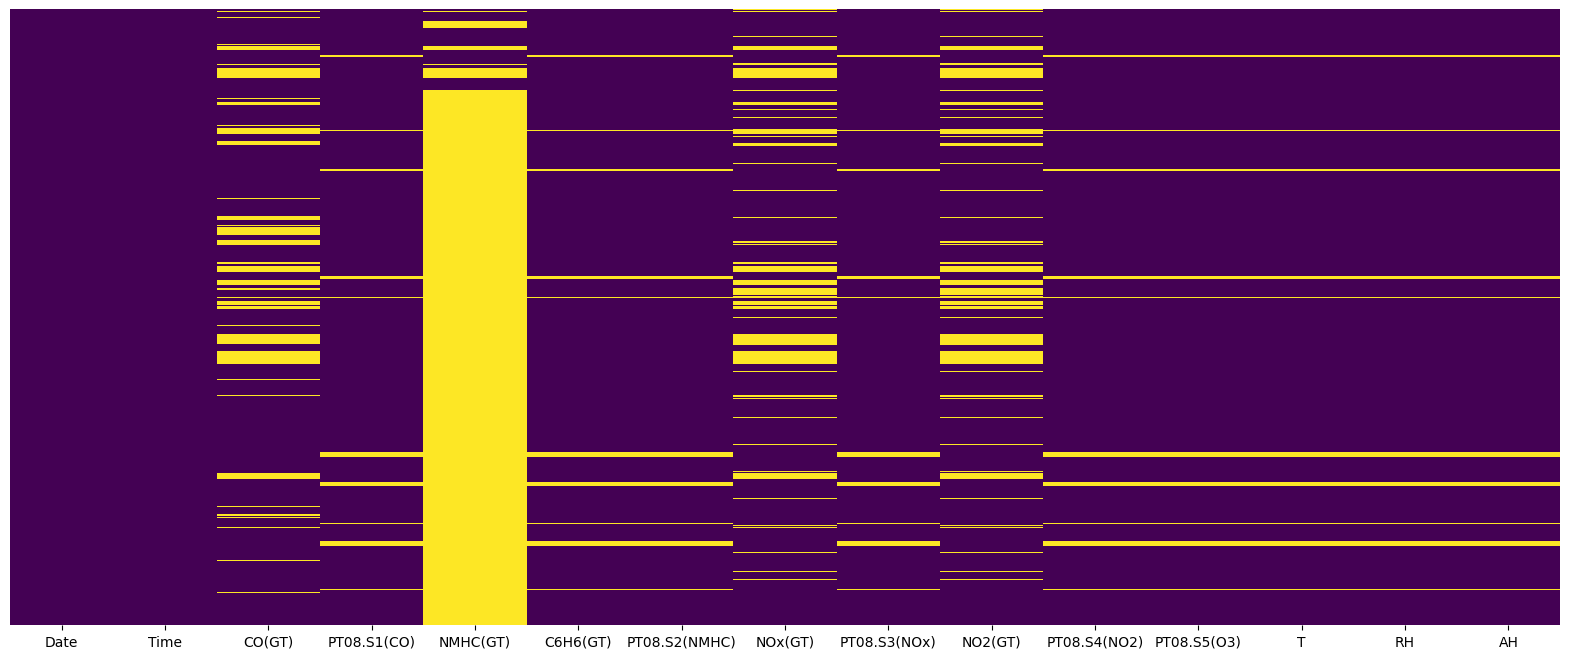

In [78]:
#Let's visualize the missing values by field. 
plt.figure(figsize=(20, 8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False, cmap='viridis')

Most of the times there is only one feature missing at a given time (6k/9k rows have only 1 missing value in the set of features). This suggests infilling methods like KNN can be suitable.

Text(0.5, 1.0, 'Histogram of nulls by number of features missing')

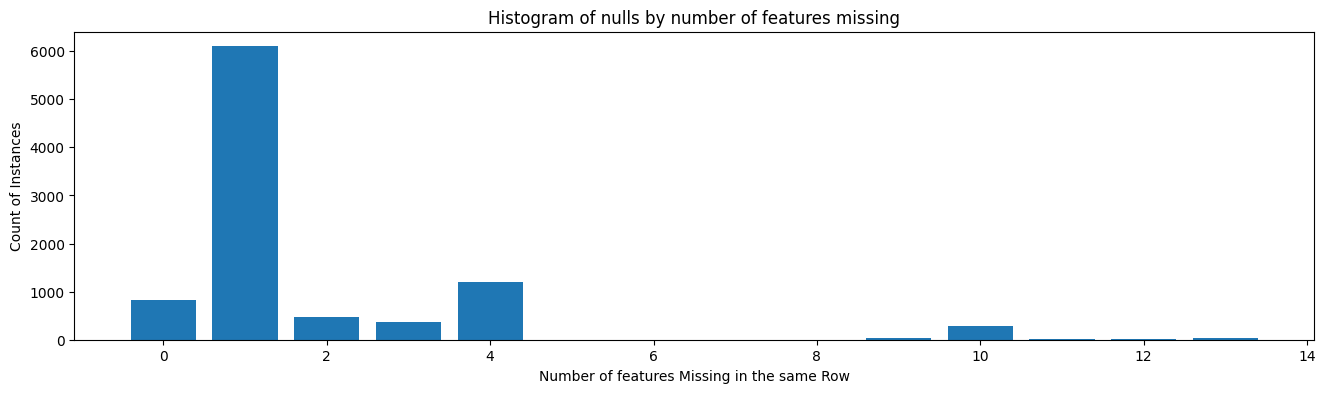

In [79]:
#Calculate number of missing features per row
dfs=df.copy()
dfs['Feature_Null_Count'] = dfs.isnull().sum(axis=1)
dfs=dfs['Feature_Null_Count'].value_counts().reset_index(name="Count").sort_values(by="Feature_Null_Count", ascending=True)
plt.figure(figsize=(16, 4))
plt.bar(dfs['Feature_Null_Count'], dfs['Count'])
plt.xlabel('Number of features Missing in the same Row')
plt.ylabel('Count of Instances')
plt.title('Histogram of nulls by number of features missing')

- Feature autocorrelations are strong within the hour. Linear interpolation may suit the infilling of sparse missing values as a first approach.
- Long-term correlations seen (>30hs). Perhaps worth trying LSTM apart from RNN? LSTM may better capture long-term relationships in the time series.

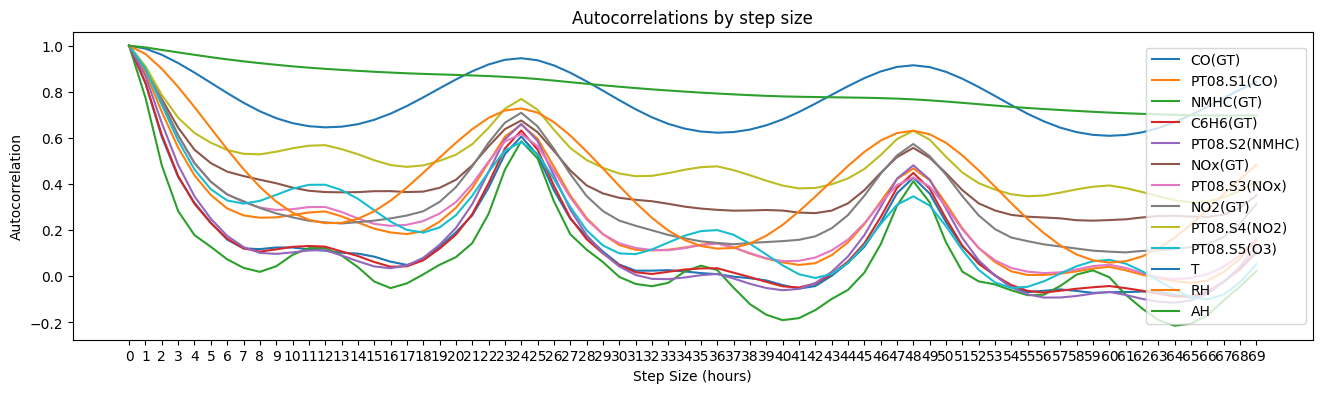

In [80]:
def plot_time_autocorrelations(df, max_time, lag):
    df = df.drop([ "Time","Date"], axis=1)
    autocorrelations_lags=[]
    lags = list(range(0, max_time, lag)) 
    for lag in lags:
        autocorrelations_lag= df.apply(lambda col: col.autocorr(lag=lag))
        autocorrelations_lag=autocorrelations_lag.reset_index().rename(columns={'index': 'Gas', 0: str(lag)})
        autocorrelations_lags.append(autocorrelations_lag)
    merged_df = reduce(lambda left, right: pd.merge(left, right, on="Gas"), autocorrelations_lags)

    #Let's plot it
    plt.figure(figsize=(16, 4))
    for index, row in merged_df.iterrows():
        plt.plot(row.index[1:], row.values[1:], label=row['Gas'])
    plt.xlabel('Step Size (hours)')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelations by step size')
    plt.legend(loc='center right')
    plt.show()

plot_time_autocorrelations(df, max_time=70, lag=1)

### 6. Preprocessing <a id="preprocessing"></a>
Informed by the data exploration, in this section:
- The feature NMHC(GT) is removed since 90% of its rows contain missing values.
- We infill missing values of the rest of the dataset in two steps:
    - First, we linearly interpolate the sparse missing values, where only one or two hours are missing between two valid measurements. 
    - Then, we infill the rest of the dataset using k-nearest neighbours.
- An example is provided to compare the raw data with the infilled data after the imputation.

The feature NMHC(GT) is removed since 90% of its rows contain missing values.

In [81]:
#The percentage of missing information in NMHC(GT) is too high (>90%). We delete this feature as it can't be used.
df = df.drop('NMHC(GT)', axis=1)
df_noinf=df.copy() #Copy done to compare later on with the inferred values.

First, we linearly interpolate the sparse missing values, where only a missing value is present between two hours with valid measurements. 

In [82]:
#Let's impute data by interpolating before and after the gap if the there are a maximum of 2 hours empty at once.
def cluster_size_only_nans(column, cluster_size):
    if pd.isna(column)==False:
        cluster_size=0
    else:
        cluster_size=cluster_size
    return cluster_size

def get_size_missing_nan_clusters(df, column):
    cluster_column_name= "Cluster_Size"
    mask = df[column].isnull()
    df['Cluster'] = mask.ne(mask.shift()).cumsum()
    df2 = df.groupby('Cluster').size().reset_index(name=cluster_column_name)
    df=df.merge(df2, left_on="Cluster", right_on="Cluster", how="inner")
    df[cluster_column_name] = df.apply(lambda row: cluster_size_only_nans(row[column], row[cluster_column_name]), axis=1)
    df=df.drop(["Cluster"], axis=1)
    return df

def interpolate_missing_vals(df, column, hour_cut_off):
    clust_sizes=list(range(0,hour_cut_off))
    df1=df[~df["Cluster_Size"].isin(clust_sizes)]
    df2=df[df["Cluster_Size"].isin(clust_sizes)]
    df2[column] = df2[column].interpolate(method='linear')
    df=pd.concat([df1,df2], ignore_index=True)
    return df

def run(df, column, hour_cut_off):
    df=get_size_missing_nan_clusters(df, column)
    df=interpolate_missing_vals(df, column, hour_cut_off)
    df=df.drop(["Cluster_Size"], axis=1)
    return df

columns= ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH']

for column in columns:
     df=run(df, column, hour_cut_off=2)

percentage_by_column = df.apply(lambda col: round(col.isnull().sum() / len(col) * 100, 2))
print(percentage_by_column)

Date              0.00
Time              0.00
CO(GT)           16.52
PT08.S1(CO)       3.89
C6H6(GT)          3.89
PT08.S2(NMHC)     3.89
NOx(GT)          14.13
PT08.S3(NOx)      3.89
NO2(GT)          14.18
PT08.S4(NO2)      3.89
PT08.S5(O3)       3.89
T                 3.89
RH                3.89
AH                3.89
dtype: float64


Then, we infill the rest of the dataset using k-nearest neighbors.
- First, we keep only the relevant features, this means removing date and time fields.
- Since k-nearest neighbors (KNN) is sensitive to the scale of the features, scaling is performed to ensure that all features contribute equally to the distance measures. If features are not on a similar scale, KNN may give more weight to variables with larger magnitudes, potentially leading to inaccurate results.
- A smaller k will make the algorithm more sensitive to noise, while a larger k will make it more robust but may smooth out decision boundaries. In this exercise k=3.
- Finally, the data is brought back to its original scale, date & time columns are brough back and we check that the percentage of nulls by feature is now 0.
- Apart from the visual inspection performed later in this section, it would be good to perform some analysis to calibrate k and the imputation approach more rigourously. We could take data without nulls and randomly allocate nulls. Then run KNN on it to infill them and compare to the actual values by computing the MSE. We could try different k-values to find which one minimizes the losses.

In [83]:
#Let's impute the rest of the data using KNN.
date_time_cols = df[["Date", "Time"]]
df=df.drop(["Date","Time"], axis=1)
scaler = StandardScaler()
dfs_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
knn_imputer = KNNImputer(n_neighbors=3)
dfs_imputed = pd.DataFrame(knn_imputer.fit_transform(dfs_scaled), columns=dfs_scaled.columns)
dfs_imputed_original_scale = pd.DataFrame(scaler.inverse_transform(dfs_imputed), columns=df.columns)
df_final = pd.concat([date_time_cols, dfs_imputed_original_scale], axis=1)

The percentage of missing values is now 0.

In [84]:
percentage_by_column = df_final.apply(lambda col: round(col.isnull().sum() / len(col) * 100, 2))
print(percentage_by_column)

Date             0.0
Time             0.0
CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64


Let's see an example of how the imputed data looks like compared to the original dataset.

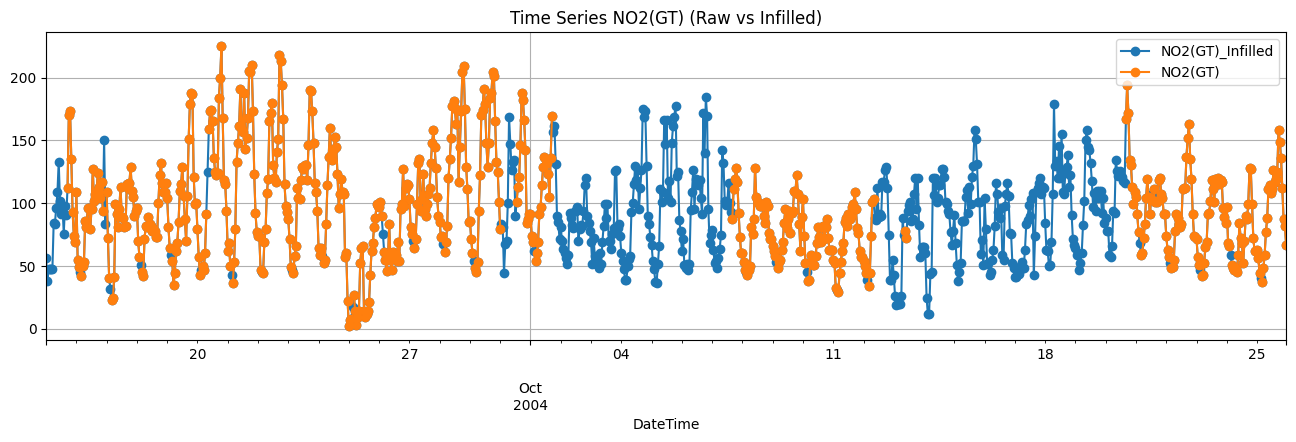

In [85]:
#First, let's define a function to combine raw and imputted data for a given feature and between two dates.
def plot_inf_vs_non_inf(df_noinf, df_final, column, date_min, date_max):

    #Turn dates into datetime types
    date_min = pd.to_datetime(date_min)
    date_max = pd.to_datetime(date_max)

    #Filter data to date interval
    df_noinf=df_noinf[(df_noinf['Date'] >= date_min) & (df_noinf['Date'] <= date_max)]
    df_final=df_final[(df_final['Date'] >= date_min) & (df_final['Date'] <= date_max)]

    #Filter for columns of interest
    df_noinf=df_noinf[["Date","Time",column]]
    df_final=df_final[["Date","Time",column]]
    df_final=df_final.rename(columns={column: column+"_Infilled"})

    #Combine both
    df2=df_noinf.merge(df_final, left_on=["Date","Time"], right_on=["Date","Time"], how="inner")

    #Combine Date and Time fields
    df2['CombinedDateTime'] = df2['Date'] + pd.to_timedelta(df2['Time'].astype(str))

    # Plotting the lines
    plt.figure(figsize=(16, 4))  
    df2.plot(x='CombinedDateTime', y=[column+"_Infilled",column], marker='o', linestyle='-', ax=plt.gca())
    plt.xlabel('DateTime')
    plt.title('Time Series ' + column + ' (Raw vs Infilled)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_inf_vs_non_inf(df_noinf, df_final, column="NO2(GT)", date_min="2004-09-15", date_max="2004-10-25")

### 7. Modelling <a id="modelling"></a>

- A Recurrent Neural Network (RNN) is a type of artificial neural network designed for sequential data processing. Unlike traditional neural networks, RNNs have connections that form directed cycles, allowing them to maintain a memory of past inputs. This makes RNNs particularly effective for tasks involving sequences, such as time series analysis. LSTMs are a type of RNN designed to address the vanishing gradient problem. They are capable of learning long-term dependencies and are often used for sequence modeling and time series prediction.
- In this section we define and train a simple LSTM with Pytorch. LSTM was chosen over a standard RNN due to the long-term autocorrelations seen during the data exploration phase.

    1. Preprocessing:
    2. Define Model.
    3. Training and Validation
    4. Prediction - Next time point.



##### 1. Preprocessing
Data scaling: Standardize the input data to facilitate training stability.


In [86]:
# Standardize the input data
df_final=df_final.drop(["Date","Time"], axis=1)
all_columns = df_final.columns 
num_features = len(all_columns)
input_data = df_final[all_columns].values.astype(float)
scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)

In [87]:
#Check the new range after the scaling (min and max)
df_input_data_scaled = pd.DataFrame(input_data_scaled, columns=df_final.columns)
df_input_data_scaled.describe()

CO(GT)   PT08.S1(CO)      C6H6(GT)  PT08.S2(NMHC)       NOx(GT)  \
count  9.312000e+03  9.312000e+03  9.312000e+03   9.312000e+03  9.312000e+03   
mean  -2.441728e-17 -6.104319e-18 -3.052160e-17  -2.380684e-16 -6.104319e-18   
std    1.000054e+00  1.000054e+00  1.000054e+00   1.000054e+00  1.000054e+00   
min   -1.398717e+00 -2.097657e+00 -1.345015e+00  -2.101306e+00 -1.126229e+00   
25%   -7.650522e-01 -7.514713e-01 -7.579196e-01  -7.647939e-01 -6.998676e-01   
50%   -2.252639e-01 -1.656205e-01 -2.429544e-01  -1.074507e-01 -3.171114e-01   
75%    4.788080e-01  5.993364e-01  5.165762e-01   6.559686e-01  3.563456e-01   
max    6.909331e+00  4.338613e+00  7.180541e+00   4.772988e+00  6.029858e+00   

       PT08.S3(NOx)       NO2(GT)  PT08.S4(NO2)   PT08.S5(O3)             T  \
count  9.312000e+03  9.312000e+03  9.312000e+03  9.312000e+03  9.312000e+03   
mean   1.281907e-16 -1.342950e-16  1.342950e-16  2.441728e-17 -2.197555e-16   
std    1.000054e+00  1.000054e+00  1.000054e+00  1.000054e+00  1.000054e+00   
min   -2.003003e+00 -2.244190e+00 -2.664722e+00 -2.019822e+00 -2.317044e+00   
25%   -6.857207e-01 -7.484169e-01 -6.380701e-01 -7.302956e-01 -7.409070e-01   
50%   -1.145054e-01 -9.533287e-02  1.111057e-02 -1.467705e-01 -4.638647e-02   
75%    5.176132e-01  5.788184e-01  6.242154e-01  6.222720e-01  7.034124e-01   
max    7.272982e+00  4.870213e+00  3.851623e+00  3.755524e+00  2.955643e+00   

                 RH            AH  
count  9.312000e+03  9.312000e+03  
mean  -8.851263e-17 -5.249714e-16  
std    1.000054e+00  1.000054e+00  
min   -2.316502e+00 -2.125811e+00  
25%   -7.781808e-01 -7.154236e-01  
50%    1.354497e-02 -5.533462e-02  
75%    7.625666e-01  6.936062e-01  
max    2.315931e+00  3.016502e+00

Sequence formation: Organize data into input sequences and target sequences. Since we are interested in predicting the next time step, let's use a sequence_length of 1.

In [88]:
# Create sequences of input data and corresponding targets
sequence_length = 1 
X, y = [], []
for i in range(len(input_data_scaled) - sequence_length):
    X.append(input_data_scaled[i:i + sequence_length])
    y.append(input_data_scaled[i + sequence_length]) #Each target value is the next data point after its respective sequence.
X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.Tensor(X)
y_tensor = torch.Tensor(y)

Split data in test and train sets for the calibration and evaluation of the model respectively.

In [89]:
# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

Create a dataloader, which will allow the model to iterate over the training dataset in batches, making it more computationally efficient. The batch size determines the number of input-output pairs processed together in each iteration during training.

In [90]:
# Create dataLoader for training set
train_dataset = TensorDataset(X_train, y_train) 
batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #Randomly shuffles the training data before each epoch, which helps in preventing the model from memorizing the order of the data and potentially improves generalization.

In [91]:
#Create dataloader for testing set
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle the test set in this case.

##### 2. Define Model
Define number of layers, hidden sizes, and output size as well as the data flow technique through the layers

In [92]:
# Step 2: Define the RNN and LSTM models.
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

#model = SimpleRNN(input_size=num_features, hidden_size=64, output_size=num_features)
model = SimpleLSTM(input_size=num_features, hidden_size=64, output_size=num_features)

Selection of loss function and the optimizer.

In [93]:
criterion = nn.MSELoss() #Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.001) #lr:Learning Rate

##### 3. Training and Validation

The training loop below performs the following steps:
- Sets the model to training mode (model.train()).
- Iterates over batches from the training DataLoader (train_loader).
- Performs the forward pass to obtain predictions.
- Computes the loss by comparing predictions with the actual targets.
- Performs the backward pass to compute gradients.
- Updates the model parameters using the optimizer (optimizer.step()).
- Prints the loss for monitoring during training.

In [94]:
epochs = 10 #This is the number of times the entire training dataset will be passed forward and backward through the neural network. Each pass through the entire dataset is called an epoch.
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # Clip gradients to prevent explosion
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.1932
Epoch 2/10, Loss: 0.0906
Epoch 3/10, Loss: 0.1253
Epoch 4/10, Loss: 0.1281
Epoch 5/10, Loss: 0.1347
Epoch 6/10, Loss: 0.1962
Epoch 7/10, Loss: 0.1068
Epoch 8/10, Loss: 0.1167
Epoch 9/10, Loss: 0.1414
Epoch 10/10, Loss: 0.0913


We then evaluate the performance of the model and get an average MSE on the Test Set. Note the MSE is calculated on the scaled features, typically ranging between -3 and 7 after applying Z-score (mean=0, stdev=1). 

In [95]:
model.eval()
mse_accumulator = 0.0 
with torch.no_grad():
    for test_inputs, test_targets in test_loader: 
        test_outputs = model(test_inputs)
        mse = criterion(test_outputs, test_targets)
        mse_accumulator += mse.item()
average_mse = mse_accumulator / len(test_loader)
print(f"Average MSE on Test Set: {average_mse:.4f}")

Average MSE on Test Set: 0.1874


##### 4. Prediction - Next time point.

Predict the next hour of data:

In [96]:
X = []
X.append(input_data_scaled[9311:9312]) #Take just the last datapoint
X_tensor = torch.Tensor(X)
model.eval()
with torch.no_grad():
    test_outputs = model(X_tensor)
predicted_values = test_outputs.numpy()
predicted_values = pd.DataFrame(predicted_values, columns=all_columns)
pd.DataFrame(scaler.inverse_transform(predicted_values), columns=all_columns) #Reverse values to original scale

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)     NOx(GT)  PT08.S3(NOx)  \
0  0.785062   908.658325  2.067807     613.514893  120.983711    987.136963   

     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)          T         RH        AH  
0  95.779808    902.519226   484.532867  13.070794  37.207436  0.586003

### 8. Question - Cross Validation <a id="question_cross_validation"></a>
**How would you apply cross validation to the model? (No code implementation required, just description of the methodology)**

Instead of a single train-test split, with a traditional cross-validation the dataset is divided into multiple subsets or "folds." The process involves repeating the training and evaluation process multiple times, equal to the number of folds. In each round, one fold is used as the test set, while the remaining folds are used for training. After each round, you compute a performance metric (e.g., accuracy, mean squared error) for the model on the test fold. You then aggregate these metrics across all rounds to get an overall performance estimate. This approach is typically used because it provides a more robust estimate of the model's performance.  

Although this approach pose benefits to the training quality of the model, it can also face challenges when applied directly to time series data:
- In time series data, the order of the samples matters, and each data point depends on its past. Traditional k-fold cross-validation ignores this temporal relationship by randomly shuffling the data for each fold, potentially leading to suboptimal performance evaluation.
- The independence assumption between folds in k-fold cross-validation is often violated in time series data, where adjacent time points are likely to be correlated. Violating this assumption can lead to overly optimistic or pessimistic performance estimates., there would be a risk of data leakage between folds that could affect the calibration.
- etc.

To address these issues, we could use time series-specific cross-validation methods, such as **TimeSeriesSplit**. These methods ensure that each fold's validation set contains data points that come after the training set, preserving the temporal order and mitigating the risk of data leakage.

In the case of TimeSeriesSplit:
- We would first split the data into a specified number of splits or folds. The first fold contains the initial portion of the data, and subsequent folds include additional data points, ensuring that each fold covers a contiguous and sequential subset of the time series.
- For each split, the model is trained on the training subset (all data points before the current fold), and its performance is evaluated on the validation subset (the current fold). This process is repeated for each split, ensuring that each data point serves as both part of the training set and the validation set.
- The process is iterated until all data points have been included in the validation set exactly once. At each iteration, the training set includes all data points that precede the current validation set, preserving the temporal order.

